In [1]:
# ! git clone https://github.com/ClaudioPaterniti/MinesweeperLearning.git

Cloning into 'MinesweeperLearning'...
remote: Enumerating objects: 391, done.
remote: Counting objects: 100% (391/391), done.
remote: Compressing objects: 100% (253/253), done.
remote: Total 391 (delta 187), reused 325 (delta 123), pack-reused 0 (from 0)
Receiving objects: 100% (391/391), 37.11 MiB | 16.42 MiB/s, done.
Resolving deltas: 100% (187/187), done.


In [2]:
# !pip install ipython-autotime
%load_ext autotime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.0 MB/s eta 0:00:00
time: 258 µs (started: 2024-11-03 09:53:57 +00:00)


In [3]:
import os
os.chdir('/content/MinesweeperLearning')

time: 426 µs (started: 2024-11-03 09:53:57 +00:00)


In [4]:
import torch
import numpy as np

import src.utils as utils

from torch.utils.data import DataLoader

from src.models.patch_mlp import MineSweeperDataset, PatchMLPModel, Game
from src.models.unet import UnetModel
from src.models.conv import ConvModel
from src.player import Player, ThresholdPlayer

time: 3 s (started: 2024-11-03 09:53:57 +00:00)


In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)
rng = np.random.default_rng()

cuda
time: 48.4 ms (started: 2024-11-03 09:54:00 +00:00)


In [143]:
data = utils.sample(np.load('data/dataset.npy'), 200_000)

time: 75.1 ms (started: 2024-11-03 11:53:03 +00:00)


In [144]:
model_type = 'conv'

time: 315 µs (started: 2024-11-03 11:53:03 +00:00)


In [ ]:
if model_type == 'patch_mlp':
    patch_radius = 3
    d = 2*patch_radius+1
    layers= [2**i for i in range(10, 0, -1)]
    name = f'patch_mlp_{d}x{d}_{layers[0]}'
    print(name)

    model = PatchMLPModel(
        patch_radius,
        layers,
        device=device)
    transform = model.transform
    weights = None
    dataset = MineSweeperDataset(data, transform, weights)

In [145]:
if model_type == 'conv':
    r, c = (16, 30)
    kernel_radius = 2
    k = 2*kernel_radius+1
    layers= [2**i for i in range(7, 0, -1)]
    name = f'conv_{k}x{k}_{layers[0]}'
    print(name)

    model = ConvModel(
        kernel_radius,
        layers,
        device=device)
    transform = model.transform
    weights = ((data == 9) | (data == -1)).view(np.int8)
    dataset = MineSweeperDataset(data, transform, weights)

conv_5x5_128
time: 625 ms (started: 2024-11-03 11:53:06 +00:00)


In [58]:
if model_type == 'unet':
    r, c, m = (16, 30, 99)
    decoder_shapes = [(128, 16, 30), (256, 8, 15), (512, 4, 7)]
    name = f'unet_{r}x{c}_{decoder_shapes[0][0]}'
    print(name)

    model = UnetModel(
        map_size=(r, c),
        decoder_shapes=decoder_shapes,
        device=device)
    transform = model.transform
    weights = ((data == 9) | (data == -1)).view(np.int8)
    dataset = MineSweeperDataset(data, transform, weights)

unet_16x30_64
time: 631 ms (started: 2024-11-03 10:30:32 +00:00)


In [146]:
batch_size = 128
training_data, test_data = torch.utils.data.random_split(dataset, (0.95, 0.05))
train_dataloader = DataLoader(training_data, batch_size, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(training_data, batch_size, num_workers=4, pin_memory=True)
player = ThresholdPlayer(model, 0.01, 0.95)
optimizer = torch.optim.Adam(model.model.parameters(), lr=0.001)

time: 15.2 ms (started: 2024-11-03 11:53:11 +00:00)


In [147]:
test_games = Game(n = 500)
zeros = test_games.open_zero()

time: 12.4 ms (started: 2024-11-03 11:53:12 +00:00)


In [148]:
train_loss = []
test_loss = []
win_rate = []

stop_if_no_max_after = -1
max_win_rate, argmax_t = 0, 0

time: 583 µs (started: 2024-11-03 11:53:16 +00:00)


In [149]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(model.train(train_dataloader, optimizer))
    player.play(test_games)
    win_rate.append(test_games.win_rate())
    print(f"win rate: {win_rate[-1]}")
    test_games.reset()
    test_games.move(zeros)
    test_loss.append(model.test(test_dataloader))
    if win_rate[-1] > max_win_rate:
      model.save(os.path.join('weights', name + '_max.pth'))
      max_win_rate = win_rate[-1]
    if win_rate[-1] > max_win_rate - 0.01:
      argmax_t = t
    elif stop_if_no_max_after > 0 and t - argmax_t >= stop_if_no_max_after:
        break

Epoch 1
-------------------------------
win rate: 0.296
Epoch 2
-------------------------------
win rate: 0.392
Epoch 3
-------------------------------
win rate: 0.442
Epoch 4
-------------------------------
win rate: 0.418
Epoch 5
-------------------------------
win rate: 0.424
Epoch 6
-------------------------------
win rate: 0.474
Epoch 7
-------------------------------
win rate: 0.428
Epoch 8
-------------------------------
win rate: 0.404
Epoch 9
-------------------------------
win rate: 0.392
Epoch 10
-------------------------------
win rate: 0.384
time: 7min 27s (started: 2024-11-03 11:53:20 +00:00)


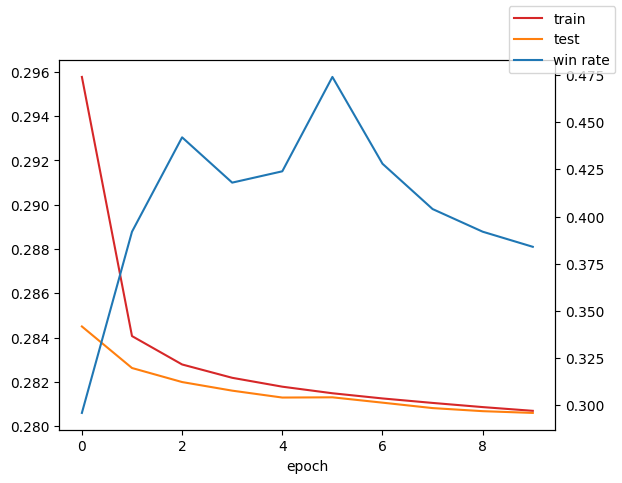

time: 277 ms (started: 2024-11-03 12:00:48 +00:00)


In [150]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.set_xlabel('epoch')

ax1.plot(train_loss, color='tab:red', label = 'train')
ax1.plot(test_loss, color='tab:orange', label = 'test')

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(win_rate, color=color, label = 'win rate')

fig.legend(loc="upper right")
plt.show()

In [151]:
model.save(os.path.join('weights', name + '.pth'))
torch.save(optimizer.state_dict(), os.path.join('weights', name + '.opt'))

time: 31.1 ms (started: 2024-11-03 12:00:56 +00:00)


In [152]:
model_reference = ConvModel.load('weights/conv_5x5_128_max.pth', device)
player_reference = ThresholdPlayer(model_reference, 0.01, 0.99)
test_player = ThresholdPlayer(model, 0.01, 0.99)

time: 38.9 ms (started: 2024-11-03 12:00:57 +00:00)


In [153]:
games = Game(16, 30, 99, 20000)
z = games.open_zero()
player_reference.play(games)
print(f'player_reference: average score: {np.average(games.scores(final_only=True))}')
print(f'\twin rate: {games.win_rate()}')
reference_won = games.won.copy()

player_reference: average score: 0.8704868766404201
	win rate: 0.4401
time: 1min 1s (started: 2024-11-03 12:00:58 +00:00)


In [ ]:
# 0.44305
games.reset()
games.move(z)
test_player.play(games)
print(f'test_player: average score: {np.average(games.scores(final_only=True))}')
print(f'\twin rate: {games.win_rate()}')

In [49]:
reinforce_iterations = 1
epochs = 1
base_size, reinforce_size = 10_000, 10_000
losing_move_weight = 2
for i in range(reinforce_iterations):
  base = utils.sample(data, base_size)
  games = Game(16, 30, rng.normal(99, 30, reinforce_size*3).astype(int).clip(40, 160), reinforce_size*3)
  games.open_zero()
  print("Playing games")
  player.play(games)
  print("Computing weights")
  lost_idx = np.logical_not(games.won)
  lost = games.as_dataset()[lost_idx]
  data = np.concatenate([base, lost])
  base_weights = ((base == 9) | (base == -1)).view(np.int8)
  losing_weights = ((lost == 9) | (lost == -1)).view(np.int8)*(np.abs(games.losing_moves()[lost_idx])*losing_move_weight)
  weights = np.concatenate([base_weights, losing_weights])
  train_data = MineSweeperDataset(data, transform, weights)
  train_dataloader = DataLoader(train_data, batch_size, num_workers=4, pin_memory=True, shuffle=True)
  for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      train_loss.append(model.train(train_dataloader, optimizer))
      player.play(test_games)
      win_rate.append(test_games.win_rate())
      print(win_rate[-1])
      test_games.reset()
      test_games.move(zeros)
      test_loss.append(model.test(test_dataloader))

Playing games
Computing weights
Epoch 1
-------------------------------
0.384
time: 1min 59s (started: 2024-11-03 10:26:31 +00:00)


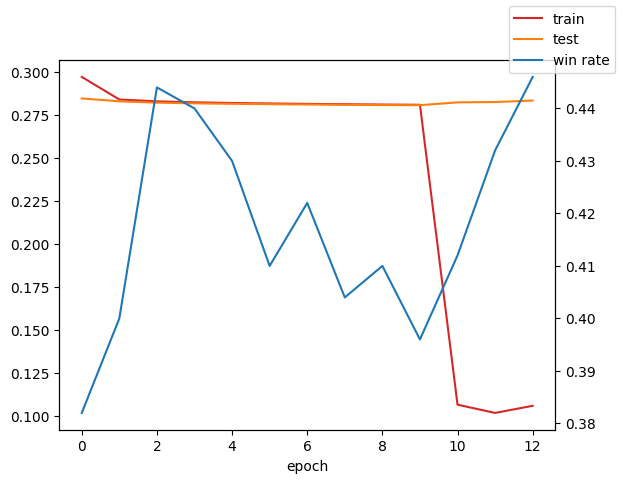

time: 266 ms (started: 2024-11-03 10:22:06 +00:00)


In [45]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('epoch')

ax1.plot(train_loss, color='tab:red', label = 'train')
ax1.plot(test_loss, color='tab:orange', label = 'test')

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(win_rate, color=color, label = 'win rate')

fig.legend(loc="upper right")
plt.show()

In [46]:
model.save(os.path.join('weights', name + '_reinforced.pth'))
torch.save(optimizer.state_dict(), os.path.join('weights', name + '_reinforced.opt'))

time: 28.3 ms (started: 2024-11-03 10:22:53 +00:00)


In [47]:
games = Game(16, 30, 99, 10000)
z = games.open_zero()
player_reference.play(games)
print(f'player_reference: average score: {np.average(games.scores(final_only=True))}')
print(f'\twin rate: {games.win_rate()}')
reference_won = games.won.copy()

player_reference: average score: 0.873263254593176
	win rate: 0.4369
time: 35.8 s (started: 2024-11-03 10:22:54 +00:00)


In [48]:
games.reset()
games.move(z)
test_player.play(games)
print(f'test_player: average score: {np.average(games.scores(final_only=True))}')
print(f'\twin rate: {games.win_rate()}')

test_player: average score: 0.8428220472440944
	win rate: 0.405
time: 40.8 s (started: 2024-11-03 10:23:30 +00:00)
